In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%cd ..

C:\Users\Dimitri\workspaces\opensource\quantum-machine-learning


C:\Users\Dimitri\anaconda3\envs\quantum-machine-learning\Lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


$
\newcommand{\ket}[1]{\left|{#1}\right\rangle}
\newcommand{\bra}[1]{\left\langle{#1}\right|}
\newcommand{\braket}[2]{\left\langle{#1}\middle|{#2}\right\rangle}
$

# Improving Amplitude Embedding for Quantum Machine Learning

### Motivation

Amplitude embedding is a classical to quantum embedding where every classical dimension is embedded as an amplitude of a vector in the Hilbert space of qubits. Since $n$ qubits generate a $2^n$-dimensional space, the number of qubits required is logarithmic in the number of classical dimensions. This means that amplitude embedding provides a natural compression algorithm as well as an embedding mechanism.

Unfortunately, amplitude embedding does not perform well in practice. In this report, we investigate the causes for the failure of amplitude embedding and propose a solution to rectify it.

## Problem Description

The state space of $n$ qubits is a $2^n$-dimensional Hilbert space. Each state has a representation

$$
\ket{x} = \sum_{k=0}^{2^n} a_k \ket{k}
$$

Where the $a_k$ are complex numbers such that $\sum_k |a_k|^2 = 1$. 
This means that we can embed a maximum of $2^n$ classical features using just $n$ qubits, provided that we impose this normalization condition.

The normalization condition however, poses a problem: If we have $M$ features, we map then on a $M-1$ sphere which means we lose one dimension. The loss of one dimension is not so much of a problem as is the fact that this mapping does not preserve distance.
Points that are far apart in the original feature space may end up close on the sphere surface if their angles are close to each other. 

## Problem Demonstation

We demonstrate the problem visually using a simple dataset. We start with the famous iris dataset and we simplify it by keeping only 2 out of the 4 features. We will show how amplitude embedding distorts the feature space.

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.decomposition import PCA
from sklearn.datasets import load_iris, load_breast_cancer
import numpy as np
import matplotlib.pyplot as plt
from utils.preprocess import scale_for_angle_encoding, scale_for_amplitude_encoding
from penny.classifier import BinaryClassifier, ClassifierContext
from penny.models import *

In [4]:
# Load the iris dataset 
iris_features, iris_labels = load_iris(return_X_y=True)
# Keep only two features
iris_reduced_features = iris_features[:, [0,2]]
iris_reduced_features.shape

(150, 2)

In [5]:
# Plot the labels in feature space
scaler = StandardScaler()
iris_scaled_reduced_features = scaler.fit_transform(iris_reduced_features)

Text(0.5, 1.0, 'Iris classes in original 2D space')

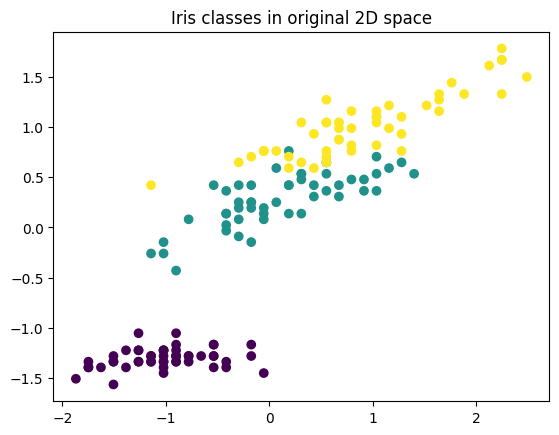

In [6]:
plt.scatter(iris_scaled_reduced_features[:,-0], iris_scaled_reduced_features[:,1], c=iris_labels)
plt.title('Iris classes in original 2D space')

We can see that the classes are reasonably separated. Now let's see what happens when we normalize for amplitude encoding.

Text(0.5, 1.0, 'Iris classes in Amplitude embedding space')

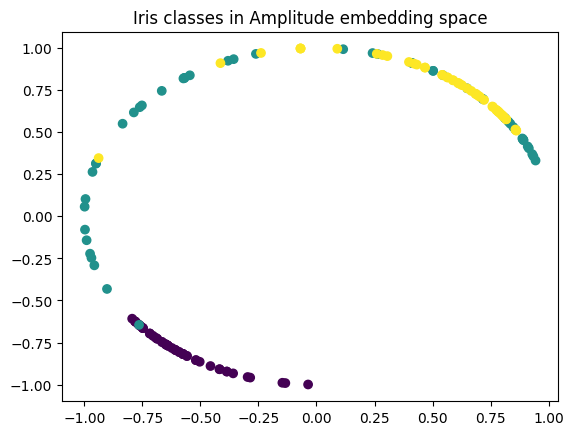

In [7]:
# Now, scale for amplitude embedding
iris_amplitude_scaled_features = scale_for_amplitude_encoding(iris_scaled_reduced_features)
plt.scatter(iris_amplitude_scaled_features[:, 0], iris_amplitude_scaled_features[:, 1], c=iris_labels)
plt.title('Iris classes in Amplitude embedding space')

We can see that the projection on the circle mixes some of the features that appeared separable in the original diagram.

## The Solution

Since the stereographic projection onto the sphere distorts the features, we would like to find a more faithful mapping from the original feature space to the sphere space. One way of doing this is instead of embedding into an $M-1$ dimensional sphere, 
we can map the feature space onto an $M$-dimensional sphere so that we preserve the dimension.

One way of doing this, is to use the stereographic projection of a hyper-plane onto a hyper-sphere of the same dimension.

In particular, given a vector $X \in \mathbb{R}^M$, we can map it to an $M$-dimensional sphere embedded in $\mathbb{R}^{M+1}$ 
by the inverse stereographic projection:

$$
x_0 = \frac{s^2-1}{s^2+1}
$$

$$
x_i = \frac{2X}{s^2+1}
$$

where $s^2 = \sum_k X_k^2$

In [8]:
# Function to compute the stereographic projection

def inverse_stereographic_projection(X):
    s2 = np.sum(np.square(X))
    return np.hstack([(s2-1)/(s2+1), 2*X/(s2+1)])

In [9]:
features_sp = np.apply_along_axis(inverse_stereographic_projection, 1, iris_scaled_reduced_features)
features_sp.shape

(150, 3)

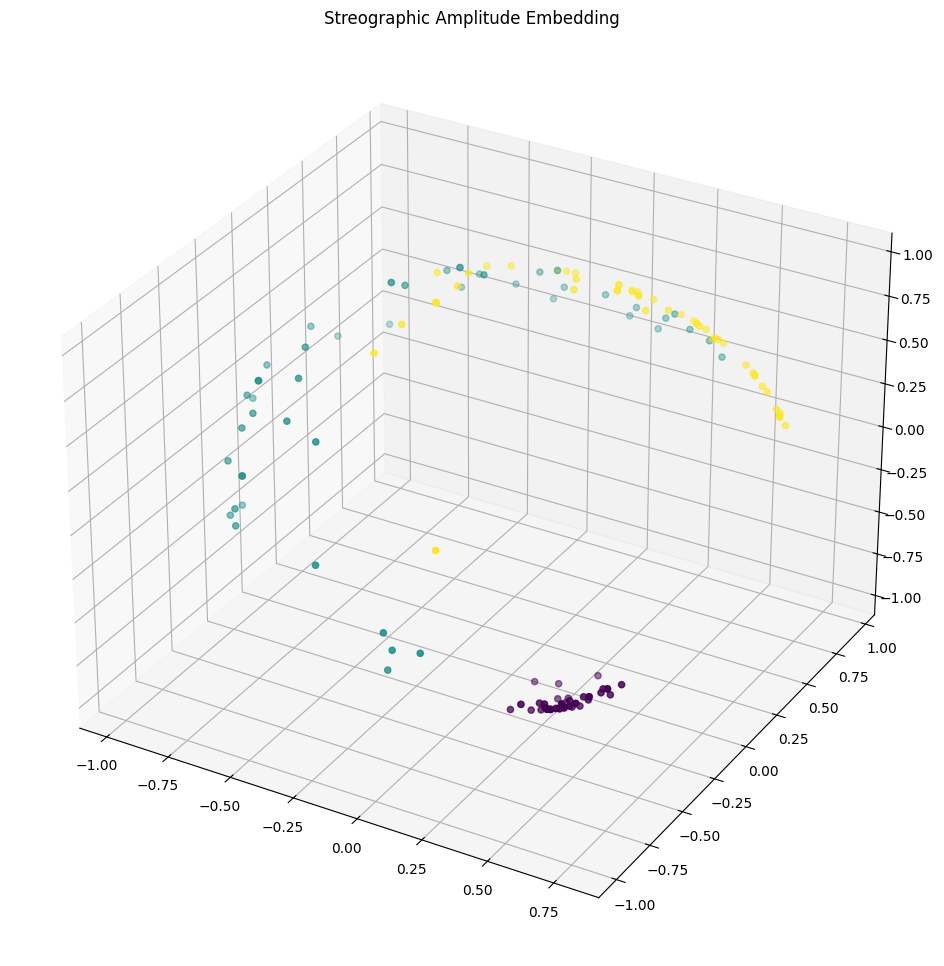

In [10]:
# Visualization of the projection for the iris dataset
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
ax.scatter(features_sp[:, 0], features_sp[:, 1], features_sp[:, 2],
          c=iris_labels)
plt.title('Streographic Amplitude Embedding')
plt.show()

It looks like we can obtain better separation between classes.

# Application to QML

We are going to demonstrate the effect of "fixing" the amplitude embedding via stereographic projection on a simple machine learning problem. We will perform QML with a VQC on the Wisconsin Cancer data set which has 30 predictors.


In [11]:
np.random.seed(9999)

In [12]:
# Get the dataset, scale, and divide into training and test set

features, y = load_breast_cancer(return_X_y=True)
# convert from 0/1 to -1/1
y[y == 0] = -1
# scale
X = StandardScaler().fit_transform(features)

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.2)

In the first experiment will use Angle Embedding which requires as many qubits as there are features. 
Since we cannot run a simulator with 30 qubits, we will use PCA to reduce the number of qubits

In [13]:
num_features = 5

pca = PCA(n_components=num_features)
X_train_pca = pca.fit_transform(X_train)
X_train_scaled = scale_for_angle_encoding(X_train_pca)
X_test_pca = pca.transform(X_test)
X_test_scaled = scale_for_angle_encoding(X_test_pca)

In [14]:
pca_5_accuracy = []

def capture_progress(classifier_context: ClassifierContext):
    iteration = classifier_context.current_iteration
    classifier = classifier_context.classifier
    predictions = classifier.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, predictions)
    pca_5_accuracy.append(accuracy)
    if (iteration + 1) % 10 == 0:
         print(f"Iter: {iteration + 1:5d} | Accuracy: {accuracy:0.7f} ")

num_qubits = num_features
num_layers = 3
classifier = BinaryClassifier(model=StronglyEntangledBinaryModel(num_qubits),
                                  weights_shape=(3, num_qubits, 3),
                                  device="lightning.qubit",
                                  iterations=100,
                                  report_fn=capture_progress)
classifier.fit(X_train_scaled, y_train)

Iter:    10 | Accuracy: 0.3157895 
Iter:    20 | Accuracy: 0.3596491 
Iter:    30 | Accuracy: 0.5964912 
Iter:    40 | Accuracy: 0.7982456 
Iter:    50 | Accuracy: 0.8596491 
Iter:    60 | Accuracy: 0.8771930 
Iter:    70 | Accuracy: 0.8947368 
Iter:    80 | Accuracy: 0.9122807 
Iter:    90 | Accuracy: 0.9035088 
Iter:   100 | Accuracy: 0.9122807 


In [15]:
predictions_test = classifier.predict(X_test_scaled)
cr = classification_report(y_test, predictions_test)
print(cr)

              precision    recall  f1-score   support

          -1       0.81      0.94      0.87        36
           1       0.97      0.90      0.93        78

    accuracy                           0.91       114
   macro avg       0.89      0.92      0.90       114
weighted avg       0.92      0.91      0.91       114



In the second experiment, we are going to use straight up Amplitude Encoding. Since we have 30 features, 
we require $\lceil log_2 30 \rceil = 5$ qubits 

In [28]:
X_train_ampl = scale_for_amplitude_encoding(X_train)
X_test_ampl = scale_for_amplitude_encoding(X_test)

amplitude_accuracy = []

def capture_progress(classifier_context: ClassifierContext):
    iteration = classifier_context.current_iteration
    classifier = classifier_context.classifier
    predictions = classifier.predict(X_test_ampl)
    accuracy = accuracy_score(y_test, predictions)
    amplitude_accuracy.append(accuracy)
    if (iteration + 1) % 10 == 0:
         print(f"Iter: {iteration + 1:5d} | Accuracy: {accuracy:0.7f} ")
            

num_qubits = 5
model = StronglyEntangledBinaryModel(num_qubits, embedding_fn=amplitude_embedding_fn)
classifier = BinaryClassifier(model=model,
                                  weights_shape=(3, num_qubits, 3),
                                  device="lightning.qubit",
                                  iterations=100,
                                  report_fn=capture_progress)
classifier.fit(X_train_ampl, y_train)

Iter:    10 | Accuracy: 0.6842105 
Iter:    20 | Accuracy: 0.6929825 
Iter:    30 | Accuracy: 0.6842105 
Iter:    40 | Accuracy: 0.7105263 
Iter:    50 | Accuracy: 0.6842105 
Iter:    60 | Accuracy: 0.6929825 
Iter:    70 | Accuracy: 0.6929825 
Iter:    80 | Accuracy: 0.7017544 
Iter:    90 | Accuracy: 0.7017544 
Iter:   100 | Accuracy: 0.7105263 


In [29]:
predictions_test = classifier.predict(X_test_scaled)
cr = classification_report(y_test, predictions_test)
print(cr)

              precision    recall  f1-score   support

          -1       0.75      0.25      0.38        36
           1       0.74      0.96      0.83        78

    accuracy                           0.74       114
   macro avg       0.74      0.61      0.60       114
weighted avg       0.74      0.74      0.69       114



The results are not great. Finally, we are going to use amplitude embedding with stereographic projection. To achieve this, we need to add one dimension, so we need 6 qubits.

In [30]:
# Define the inverse stereographic projection

num_qubits = 5

def inverse_stereographic_projection(X):
    s2 = np.sum(np.square(X))
    return np.hstack([(s2-1)/(s2+1), 2*X/(s2+1)])


In [31]:
X_train_stereo = np.apply_along_axis(inverse_stereographic_projection, 1, X_train)
X_test_stereo = np.apply_along_axis(inverse_stereographic_projection, 1, X_test)

stereographic_accuracy = []

def capture_progress(classifier_context: ClassifierContext):
    iteration = classifier_context.current_iteration
    classifier = classifier_context.classifier
    predictions = classifier.predict(X_test_stereo)
    accuracy = accuracy_score(y_test, predictions)
    stereographic_accuracy.append(accuracy)
    if (iteration + 1) % 10 == 0:
         print(f"Iter: {iteration + 1:5d} | Accuracy: {accuracy:0.7f} ")
            
model = StronglyEntangledBinaryModel(num_qubits, embedding_fn=amplitude_embedding_fn)
classifier = BinaryClassifier(model=model,
                                  weights_shape=(3, num_qubits, 3),
                                  device="lightning.qubit",
                                  iterations=100,
                                  report_fn=capture_progress)
classifier.fit(X_train_stereo, y_train)

Iter:    10 | Accuracy: 0.6842105 
Iter:    20 | Accuracy: 0.6842105 
Iter:    30 | Accuracy: 0.8684211 
Iter:    40 | Accuracy: 0.8596491 
Iter:    50 | Accuracy: 0.8859649 
Iter:    60 | Accuracy: 0.8947368 
Iter:    70 | Accuracy: 0.8947368 
Iter:    80 | Accuracy: 0.8596491 
Iter:    90 | Accuracy: 0.9035088 
Iter:   100 | Accuracy: 0.9210526 


In [33]:
predictions_test = classifier.predict(X_test_stereo)
cr = classification_report(y_test, predictions_test)
print(cr)

              precision    recall  f1-score   support

          -1       0.97      0.78      0.86        36
           1       0.91      0.99      0.94        78

    accuracy                           0.92       114
   macro avg       0.94      0.88      0.90       114
weighted avg       0.92      0.92      0.92       114



C:\Users\Dimitri\AppData\Local\Temp\ipykernel_37300\3871871818.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


<Axes: title={'center': 'Performance comparison for Amplitude Embedding'}>

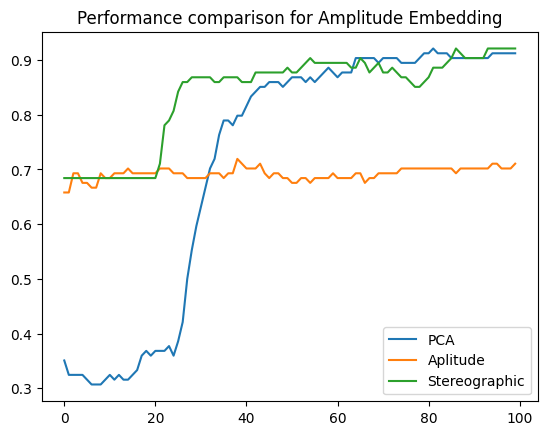

In [35]:
import pandas as pd

df = pd.DataFrame(list(zip(pca_5_accuracy, amplitude_accuracy, stereographic_accuracy)), 
                  columns=['PCA', 'Aplitude', 'Stereographic'])
df.plot(title='Performance comparison for Amplitude Embedding')

# Conclusion

We have demonstrate that a naive application of Amplitude embedding leads to poor performance results due to the distortion of the feature space. We proposed a method by which we can encode the amplitudes in a hypersphere of higher dimension which reduces the distortion and is better at preserving the distance in feature space. 

We have used this new technique to train a simple classification dataset and we have seen that we can achieve better performance than by using classical dimensionality reduction methods such as PCA.

